# Algoritmo Genético Versão Ensamble

Essa versão inclui:
- Otimização da rota (V1)
- Otimização da quantidade de waypoints (V2)
- Risco Inflado: Inflação das áreas não-navegáveis (V3)
- Alocação de risco (V3.5)

# 1. Utils
Essa seção contém funções auxiliares para o algoritmo.

## utils.py

In [159]:
import itertools
from scipy.stats import norm

# Support Functions
# _________________________________________________________________________________________________
def pairwise_circle(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ... (s<last>,s0)"
    a, b = itertools.tee(iterable)
    first_value = next(b, None)
    return itertools.zip_longest(a, b,fillvalue=first_value)

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def boundary(val, val_min, val_max):
  if val<val_min:
    return val_min
  if val>val_max:
    return val_max
  return val

# Ray Casting Algorithm
# _________________________________________________________________________________________________
epsilon = 0.00001  # Used on the Ray-Tracing Algorithm

def point_in_polygon(point, polygon):
    # Using ray_casting algorithm
    # https://rosettacode.org/wiki/Ray-casting_algorithm

    count = 0
    
    for vertex1, vertex2 in pairwise_circle(polygon):

        if vertex1.y < vertex2.y:
            A = vertex1
            B = vertex2
        else:
            A = vertex2
            B = vertex1

        if ray_intersects_segment(point, A, B):
            count += 1

    if count % 2 == 0: # Odd
        return False 
    else:
        return True # Inside the polygon
    

def ray_intersects_segment(P, A, B):
    # P : the point from which the ray starts
    # A : the end-point of the segment with the smallest y coordinate
    #     (A must be "below" B)
    # B : the end-point of the segment with the greatest y coordinate
    #     (B must be "above" A)

    # To avoid the "ray on vertex" problem, the point is moved upward of a small quantity epsilon.
    if P.y == A.y or P.y == B.y:
        P.y += epsilon

    # Point higher or lower than polygon
    if P.y < A.y or P.y > B.y:
        return False

    # Point to the right of the polygon
    elif P.x >= max(A.x, B.x):
        return False 

    else:

        if P.x < min(A.x, B.x):
            return True

        else:

            if A.x != B.x:
                m_red = (B.y - A.y)/(B.x - A.x)
            else:
                m_red = 99999999 # Infinite


            if A.x != P.x:
                m_blue = (P.y - A.y)/(P.x - A.x)
            else:
                m_blue = 99999999 # Infinite


            if m_blue >= m_red:
                return True
            else:
                return False



# Segment Intersection
# _________________________________________________________________________________________________
def segment_in_polygon(wp1, wp2, polygon):
    # count = 0
    #print('Segment: {}-{}'.format(wp1,wp2))

    for vertex1, vertex2 in pairwise_circle(polygon):
        A = vertex1
        B = vertex2
        #if vertex1.y < vertex2.y:
        #    A = vertex1
        #    B = vertex2
        #else:
        #    A = vertex2
        #    B = vertex1
        #print('Polygon edge: {}-{}'.format(A, B))

        if segment_intersects_segment(wp1, wp2, A, B):
            return True
    return False
    # if count > 1:
    #     return True 
    # else:
    #     return False 
    

def segment_intersects_segment(p1, q1, p2, q2):
    # Returns true if line segment 'p1q1' and 'p2q2' intersect. 
    # Based on the algorithm from https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

    
    # Two segments (p1,q1) and (p2,q2) intersect if and only if one of the following two conditions is verified:
    #
    # 1. General Case:
    # – (p1, q1, p2) and (p1, q1, q2) have different orientations and
    # – (p2, q2, p1) and (p2, q2, q1) have different orientations.
    #
    # 2. Special Case
    # – (p1, q1, p2), (p1, q1, q2), (p2, q2, p1), and (p2, q2, q1) are all collinear and
    # – the x-projections of (p1, q1) and (p2, q2) intersect
    # – the y-projections of (p1, q1) and (p2, q2) intersect
    
    
    # Find the four orientations needed for general and 
    # special cases 
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    #print(p2, q2, p1, o3)
    o4 = orientation(p2, q2, q1) 
    #print(o1,o2,o3,o4)
    
    # 1. General case 
    if o1 != o2 and o3 != o4:
        return True  


    # 2. Special Cases 
    # p1, q1 and p2 are colinear and p2 lies on segment p1q1 
    if o1 == 0 and on_segment(p1, p2, q1): 
        return True 
  
    # p1, q1 and q2 are colinear and q2 lies on segment p1q1 
    if o2 == 0 and on_segment(p1, q2, q1):
        return True 
  
    # p2, q2 and p1 are colinear and p1 lies on segment p2q2 
    if o3 == 0 and on_segment(p2, p1, q2):
        return True 
  
    # p2, q2 and q1 are colinear and q1 lies on segment p2q2 
    if o4 == 0 and on_segment(p2, q1, q2):
        return True 
  
    
    # Doesn't fall in any of the above cases 
    return False 
    
    
def on_segment(p, q, r):
    # Given three colinear points p, q, r, the function checks if 
    # point q lies on line segment 'pr' 
    if (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) 
    and q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y)):
        return True
    else:
        return False
    
    
def orientation(p, q, r):
    # To find orientation of ordered triplet (p, q, r). 
    # The function returns following values 
    # 0 --> p, q and r are colinear 
    # 1 --> Clockwise 
    # 2 --> Counterclockwise 
    
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/ 
    # for details of below formula. 
      
    val =( (q.y - p.y) * (r.x - q.x) 
         - ((q.x - p.x) * (r.y - q.y)))
    #print('\n---\ndebug')
    #print((q.y - p.y), (r.x - q.x), (q.x - p.x), (r.y - q.y))
    #print(val)
    if val == 0:
        return 0         # colinear

    return (1 if val > 0 else 2)  # clock or counterclock wise



# Chance Constraint
# _________________________________________________________________________________________________


def _distance_wp_area(wp, area):
    # Calculates the distance between one point P and an area area
    max_distance = - math.inf

    for A, B in pairwise_circle(area):
        distance = _distance_wp_line(wp, A, B)
        max_distance = max(max_distance, distance)

    return max_distance


def _normal(A, B):
    # Director vector
    D = Vector((A.x-B.x),(A.y-B.y))
    
    # Normalized normal vector of line AB
    aux = (math.sqrt(D.y**2+D.x**2))+1*10**(-8)
    N = Vector( (D.y)/aux, (-D.x)/aux )
    
    return N

def _distance_wp_line(P, A, B):
    # Calculates the distance between the point P and the line that crosses A and B

    #     # Director vector
    #     D = Vector((A.x-B.x),(A.y-B.y))

    #     # Normal vector of line AB
    #     # N = Vector(-D.y, D.x)

    #     # Normalized normal vector of line AB
    #     aux = (math.sqrt(D.y**2+D.x**2))+1*10**(-8)
    #     N = Vector( (D.y)/aux, (-D.x)/aux )
    N = _normal(A,B)

    b = N.x * A.x + N.y * A.y

    dist = P.x * N.x + P.y * N.y - b

    #if debug:
    #   print(A, B, P, dist)

    return dist

def d_distance_wp_line(P, A, B):
    # Calculates the distance between the point P and the line that crosses A and B

    # Director vector
    D = Vector((A.x-B.x),(A.y-B.y))

    # Normal vector of line AB
    # N = Vector(-D.y, D.x)
    
    # Normalized normal vector of line AB
    aux = (math.sqrt(D.y**2+D.x**2))+1*10**(-8)
    N = Vector( (D.y)/aux, (-D.x)/aux )

    b = N.x * A.x + N.y * A.y

    dist = P.x * N.x + P.y * N.y - b

    #if debug:
    #   print(A, B, P, dist)

    return dist, N

def _prob_collision(distance, uncertainty):
    # Survival function (also defined as 1 - cdf, but sf is sometimes more accurate).
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

    # mi    : média         : location
    # sigma : desvio padrão : scale

    return norm.sf(distance, loc=0, scale=uncertainty)


## visualization.py

In [124]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

import plotly.graph_objects as go

from sklearn import preprocessing


cor_area_nn    = '#25283d' # Yankees Blue
cor_area_p     = '#8f3985' # Plum
cor_area_b     = '#07beb8' # Tiffany Blue
cor_waypoints  = '#aa1155' # Jazzberry Jam
cor_ori_dest   = '#880044' # Pink Raspberry


def new_shape(vert, color='navajowhite', lw=.25):

    #print(vert)
    assert len(vert) >= 3, 'At least 3 vertices to form a shape'
    
    vert.append(vert[0])
    
    vertices = []
    
    for vertex in vert:
        vertices.append((vertex.x, vertex.y))
    
    colors = {
        'n': cor_area_nn,
        'p': cor_area_p,
        'b': cor_area_b
    }
    
    color = colors[color] if color in colors else color
    
    codes = [Path.MOVETO]
    for _ in range(1, len(vertices)-1):
        codes.append(Path.LINETO)
    codes.append(Path.CLOSEPOLY)
    
    path = Path(vertices, codes)

    patch = patches.PathPatch(path, facecolor=color, lw=lw, alpha=0.6)

    return patch


def plot_map(wp_style='-x', **kwargs):
    # Optional arguments:
    # areas, labels, origem, destino, waypoints, texts

    fig, ax = plt.subplots(figsize=(8,8)) 
    
    # Plot areas
    if 'areas' in kwargs and 'labels' in kwargs:
        areas=kwargs['areas']
        labels=kwargs['labels']
        patches = [ new_shape(vertice, color=label) for vertice, label in zip(areas, labels) ]
        for patch in patches:
            ax.add_patch(patch)
        
    # Plot origin and destination
    if 'origem' in kwargs and 'destino' in kwargs:
        origem=kwargs['origem']
        destino=kwargs['destino']
        ax.plot([origem.x, destino.x], [origem.y, destino.y], 'o', color=cor_ori_dest)
    
    # Plot a route with its waypoints
    if 'waypoints' in kwargs:
        waypoints=kwargs['waypoints']
        waypoints = list(map(list, zip(*waypoints)))
        ax.plot(waypoints[0], waypoints[1], wp_style, color=cor_waypoints, linewidth=2) #marker='x', linestyle='solid'
        if 'texts' in kwargs:
            for i, text in enumerate(kwargs['texts']):
                ax.annotate(text, (waypoints[0][i], waypoints[1][i]))
    
    
    # Plot multiple routes with waypoints, along with name and specific colors
    if 'multi_waypoints' in kwargs:
        for waypoints, label, color in zip(kwargs['multi_waypoints'], kwargs['names'], kwargs['colors']):
            waypoints = list(map(list, zip(*waypoints)))
            ax.plot(waypoints[0], waypoints[1], wp_style, color=color, linewidth=2, label=label) #marker='x', linestyle='solid'
            if 'texts' in kwargs:
                for i, text in enumerate(kwargs['texts']):
                    ax.annotate(text, (waypoints[0][i], waypoints[1][i]))
    
    
    
    if 'stress' in kwargs:
        # Plot waypoints
        if 'points' in kwargs:
            for wp, text in zip(kwargs['points'], kwargs['texts']):
                if text=='T':
                    in_color=cor_area_b
                else:
                    in_color=cor_waypoints

                ax.plot(wp[0], wp[1], wp_style, color=in_color, linewidth=2)
                ax.annotate(text, (wp[0], wp[1]))

        # Plot segments
        if 'segments' in kwargs and 'texts' in kwargs:
            i=0
            for segment, text in zip(kwargs['segments'], kwargs['texts']):
                X = [segment[0].x, segment[1].x]
                Y = [segment[0].y, segment[1].y]

                if text=='T':
                    in_color=cor_area_b
                else:
                    in_color=cor_waypoints
                ax.plot(X, Y, wp_style, color=in_color, linewidth=2)
                

                ax.annotate(text+str(i), (X[0], Y[0]))
                i+=1
        
        # Plot chance constraints tests
        if 'chance' in kwargs:
            
            base_das_normais = []
            
            for segment, normal, segment_text in zip(kwargs['segments'], kwargs['normals'], kwargs['segment_texts']):
                X = [segment[0].x, segment[1].x]
                Y = [segment[0].y, segment[1].y]
                ax.plot(X, Y, wp_style, color=cor_waypoints, linewidth=3)
                ax.annotate(segment_text[0], (X[0], Y[0]))
                ax.annotate(segment_text[1], (X[1], Y[1]))
                
                x = _graph_sub(segment[0].x, segment[1].x)
                y = _graph_sub(segment[0].y, segment[1].y)
                base_das_normais.append([x,y])
                ax.quiver(x, y, normal.x, normal.y, angles='xy', scale_units='xy', scale=1)
                
            for P, point_text in zip(kwargs['pointes'], kwargs['point_texts']):
                ax.plot(P.x, P.y, 'o', color=cor_area_nn, linewidth=4)
                ax.annotate(point_text, (P.x, P.y*1.05))
                
                for normal, dist in zip(base_das_normais, kwargs['distances']):
                    X = [P.x, normal[0]]
                    Y = [P.y, normal[1]]
                    ax.plot(X, Y, '', color=cor_area_nn, linewidth=2)
                    
                    x = _graph_sub(P.x, normal[0])
                    y = _graph_sub(P.y, normal[1])
                    ax.annotate(str(dist), (x, y*1.05))
    
    # Set size
    if 'margin' in kwargs:
        sl = kwargs['margin']
    else:
        sl = 1
        
    automin, automax = ax.get_xlim()
    plt.xlim(automin-sl, automax+sl)
    automin, automax = ax.get_ylim()
    plt.ylim(automin-sl, automax+sl)
    plt.gca().set_aspect('equal', adjustable='box')
    
    if 'title' in kwargs:
        plt.title(kwargs['title'])
    
    #plt.show()
    #plt.savefig('out.png')
    
    if 'save' in kwargs:
        plt.savefig(kwargs['save'])

def plot_stats(ag_trace, normalize=True):
    dft = pd.DataFrame.from_dict(ag_trace)
    
    if normalize:
        x = dft.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        dft = pd.DataFrame(x_scaled, columns=dft.columns)

    fig = go.Figure()

    for column in dft.columns:
        fig.add_trace(go.Scatter(x=dft.index, y=dft[column], name=column))
    fig.show()
    
    
def _graph_sub(A, B):
    menor = min(A, B)
    maior = max(A, B)

    return menor + ((maior - menor) / 2)

In [3]:
def vis_mapa(mapa, route=None, **qwargs):
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]

    kwargs={
        'areas': areas,
        'labels': tipos,
        'origem': mapa.origin,
        'destino': mapa.destination,
    }

    if route:
        kwargs['waypoints']=route

    kwargs.update(qwargs)

    plot_map(**kwargs)

## data_definitions.py

In [203]:
import collections
import math
import pyclipper

#CartesianPoint = collections.namedtuple('CartesianPoint', 'x y')
GeoPoint = collections.namedtuple('GeoPoint', 'latitude, longitude, altitude')
Vector = collections.namedtuple('Vector', 'x y')
Version = collections.namedtuple('Version', 'major, minor')

class CartesianPoint:
    def __init__(self, x, y, z=0):
        self.x = x
        self.y = y
        self.z = z
    
    def __repr__(self):
        return f'[{self.x}, {self.y}, {self.z}]'

class Mapa():
    def __init__(self, origin, destination, areas_n, inflation_rate=0.1, mode='scalar', verbose=False):
        self.origin = origin           # CartesianPoint : Define o ponto de partida da rota
        self.destination = destination # CartesianPoint : Define o ponto de destino da rota
        self.areas_n = areas_n         # [area, ...]
                                       # area = [CartesianPoint(),...]      
        self.areas_n_inf = [ self._inflate_area(area, inflation_rate=inflation_rate, mode=mode, verbose=verbose) for area in areas_n ]
        
        
    def _inflate_area(self, area, inflation_rate, mode, verbose):
        if mode == 'percentage':
            # Infla uma área retangular em uma porcentagem do tamanho, alterando os valores em x% de cada vértice
            x = area[2].x - area[0].x
            y = area[1].y - area[3].y

            inc = (inflation_rate)
            dec = -(inflation_rate)

            new_area = [
                CartesianPoint(area[0].x + dec * x, area[0].y + dec * y), # left,  bottom
                CartesianPoint(area[1].x + dec * x, area[1].y + inc * y), # left,  top
                CartesianPoint(area[2].x + inc * x, area[2].y + inc * y), # right, top
                CartesianPoint(area[3].x + inc * x, area[3].y + dec * y)  # right, bottom
            ]
            #new_area.append(new_area[0]) # Repetir primeiro ponto, para o ignore do shape na hora de plotar
        
        elif mode == 'scalar':
            # Infla uma área retangular em uma quantidade fixa
            inc = (inflation_rate)
            dec = -(inflation_rate)

            new_area = [
                CartesianPoint(area[0].x + dec, area[0].y + dec), # left,  bottom
                CartesianPoint(area[1].x + dec, area[1].y + inc), # left,  top
                CartesianPoint(area[2].x + inc, area[2].y + inc), # right, top
                CartesianPoint(area[3].x + inc, area[3].y + dec)  # right, bottom
            ]
            #new_area.append(new_area[0]) # Repetir primeiro ponto, para o ignore do shape na hora de plotar
        
        elif mode == 'pyclipper':
            print('\n\n-------------------  starting pyclipper')
            subj = [ [p.x,p.y] for p in area ]
            print(subj)
            pco = pyclipper.PyclipperOffset()
            pco.AddPath(subj, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)

            solution = pco.Execute(1.0)
            print(f'solution={solution}')
            new_area = [CartesianPoint(p[0],p[1]) for s in solution for p in s ]
            print(f'new_area={new_area}')
        
        
        elif mode == 'vector':
     
            lines = []
            
            for V1, V2 in pairwise_circle(area):
                N = _normal(V1, V2)
                
                NV1 = CartesianPoint(V1.x+N.x*inflation_rate, V1.y+N.y*inflation_rate)
                NV2 = CartesianPoint(V2.x+N.x*inflation_rate, V2.y+N.y*inflation_rate)
                
                a,b,c = _eq_line(NV1, NV2)
                lines.append((a,b,c))
                
                if verbose:
                    print(f'V1:{NV1} V2:{NV2}  ->  L:({a}x + {b}y + {c} = 0)')
                
                
            new_area = []
            
            for L1, L2 in pairwise_circle(lines):
                x, y = _eq_intersection_point(L1[0], L1[1], L1[2], L2[0], L2[1], L2[2])
                new_area.append(CartesianPoint(x,y))
                
                if verbose:
                    print(f'L1:({L1[0]}x + {L1[1]}y + {L1[2]} = 0) L2:({L2[0]}x + {L2[1]}y + {L2[2]} = 0)  ->  V=({x},{y})')
                
            
        
        else:
            raise Exception('Unrecognized tipe')
            
        return new_area



class Conversor():

    def list_geo_to_cart( l, geo_home):
        for i in l:
            yield Conversor.geo_to_cart(i, geo_home)

    def list_cart_to_geo( l, geo_home):
        for i in l:
            yield Conversor.cart_to_geo(i, geo_home)


    def geo_to_cart( geo_point, geo_home):
        
        def calc_y(lat, lat_):
            return (lat - lat_) * (10000000.0 / 90)
        def calc_x(longi, longi_, lat_):
            return (longi - longi_) * (6400000.0 * (math.cos(lat_ * math.pi / 180) * 2 * math.pi / 360))

        x = calc_x(geo_point.longitude, geo_home.longitude, geo_home.latitude)
        y = calc_y(geo_point.latitude, geo_home.latitude)

        #return CartesianPoint(x, y, geo_point.altitude)
        return CartesianPoint(x, y)


    def cart_to_geo( cartesian_point, geo_home):

        def calc_latitude_y(lat_, y):
            return ((y * 90) / 10000000.0) + lat_
        def calc_longitude_x(lat_, longi_, x):
            return ((x * 90) / (10008000 * math.cos(lat_ * math.pi / 180))) + longi_


        longitude_x = calc_longitude_x(geo_home.latitude, geo_home.longitude, cartesian_point.x)
        latitude_y = calc_latitude_y(geo_home.latitude, cartesian_point.y)

        #return GeoPoint(longitude_x, latitude_y, cartesian_point.z)
        return GeoPoint(longitude_x, latitude_y, 10)

In [189]:
# using general equation of line

def _eq_line(P, Q):
    # general equation of line that intersect two points P and Q
    # https://stackoverflow.com/questions/13242738/how-can-i-find-the-general-form-equation-of-a-line-from-two-points
    
    # Ax + By + C = 0
    
    A = P.y - Q.y
    B = Q.x - P.x
    C = (P.x*Q.y) - (Q.x*P.y)
    
    return A, B, C


def _eq_intersection_point(a, b, c, j, k, l):
    # find the intersection point of two lines, given their general equation arguments
    # https://stackoverflow.com/questions/13244666/how-can-i-find-the-intersection-of-two-lines-in-general-equation-form
    
    aux = (b*j - a*k)
    
    y = (a*l - c*j) / aux
    x = (c*k - b*l) / aux
    
    return x, y
    
    
    


In [ ]:
# [old] using reduced equation of line

# usign reduced form - is not good for vertical lines
# def depr_eq_line(A, B):
#     # equação da reta

#     if B.x == A.x:
#         m = 0 # Vertical line
#     else:
#         m = (B.y-A.y) / (B.x-A.x)

#     n = ((-m*A.x)+A.y)

#     # y = ax + b
#     # y = mx + n

#     return m, n


# def depr_eq_intersection_point(a1, b1, a2, b2):
#     # intersection point of two lines with respective equations:
#     # y = a1 x + b1
#     # y = a2 x + b2

#     if a1 == a2:
#         raise Exception(f'Lines are parallel, therefore there is no intersection point. Line 1: y = {a1}x +{b1}, Line 2: y = {a2}x + {b2}')

#     x = b2-b1/a1-a2
#     y = a1*x+b1

#     return x,y

## file_manipulation.py

In [5]:
def upload_mapa(mapa_file, mapa_id):
    mapa = mapa_file[mapa_id]

    geo_home = GeoPoint(mapa['geo_home'][1], mapa['geo_home'][0], mapa['geo_home'][2])

    areas_bonificadoras  = [ Conversor.list_geo_to_cart(area['geo_points'], geo_home) for area in mapa['areas_bonificadoras'] ]
    areas_penalizadoras  = [ Conversor.list_geo_to_cart(area['geo_points'], geo_home) for area in mapa['areas_penalizadoras'] ]
    
    areas_nao_navegaveis = []
    for area in mapa['areas_nao_navegaveis']:
        geo_points=[]
        for geo_point in area['geo_points']:
            geo_points.append(Conversor.geo_to_cart(
                GeoPoint(geo_point[1], geo_point[0], geo_point[2]) 
                , geo_home))
        geo_points.append(geo_points[0])
        areas_nao_navegaveis.append(geo_points)



    return geo_home, areas_bonificadoras, areas_penalizadoras, areas_nao_navegaveis

# 2. Algoritmo Genético
Essa seção contém a implementação do algoritmo genético, contendo a definição da classe indivíduo (Subject) e da classe do genético (Genetic).

### Utilitários

In [6]:
import collections
import random
import time
import copy

from math import cos, sin, sqrt, ceil

from itertools import tee
#from utils import pairwise, point_in_polygon, segment_in_polygon

Gene           = collections.namedtuple('Gene', 'a e')
GeneDecoded    = collections.namedtuple('GeneDecoded', 'x y v al')

## 2.1. Definição do Indivíduo

In [7]:
class Subject():
    
    # codificação - u
    # dna = [Gene, ...]
    #     Gene = [a, e]
    #         a = float: aceleração
    #         e = float: variação angular


    # decodificação - x
    # dna_decoded = [GeneDecoded, ...]
    #     GeneDecoded = (x, y, v, al)
    #         x  = : Posição do VANT no eixo x (aka px)
    #         y  = : Posição do VANT no eixo y (aka py)
    #         v  = : Velocidade do VANT na horizontal
    #         al = : ângulo (direção) do VANT na horizontal
    def __init__(
        self,
        px0=10.,
        py0=10.,
        v0=0,
        al0=0,
        v_min=11.1,
        v_max=30.5,
        e_min=-3,        
        e_max=3,
        a_min=-2.0,
        a_max=2.0,
        T=10,
        T_min=1,
        T_max=7,
        delta_T=1,
        m=743.0,
        mutation_prob=0.7,
        start_time=None,
        spawn_mode='random',
        version=None,
        **kwargs
    ):
        # VANT
        # px0   int : Posição inicial no eixo x (m)
        # py0   int : Posição inicial no eixo y (m)
        # v0    int : Velocidade Inicial (m/s)
        # al0   int : Ângulo inicial (graus)
        self.gene_decoded_0 = GeneDecoded(px0, py0, v0, al0) # GeneDecoded : objeto contendo o gene decodificado de posição 0
        self.v_min = v_min # float : Velocidade máxima (m/s)
        self.v_max = v_max # float : Velocidade mínima (m/s)
        self.e_min = e_min # int   : Velocidade angular mínima (graus/s)
        self.e_max = e_max # int   : Velocidade angular máxima (graus/s)
        self.a_min = a_min # float : Aceleração mínima (m/s**2)
        self.a_max = a_max # float : Aceleração máxima (m/s**2)
        
        # TODO9:implementar os initialize
        
        # Modelo
        self.T_min   = T_min   # int : Valor mínimo para o horizonte de planejamento
        self.T_max   = T_max   # int : Valor máximo para o horizonte de planejamento
        self.delta_T = delta_T # int : Discretização do tempo (s) Tempo que leva de um waypoint até o outro
        self.m       = m       # float : Massa do VANT (!=0) (gramas)
    
        # Parametros do indivíduo
        self.mutation_prob = mutation_prob # float : Probabilidade de ocorrer uma mutação no dna (%)
        self.fitness       = None          # float : Fitness do indivíduo
        #self.birth_time    = None          # time  : Hora que o indivíduo é criado
        self.dna           = None          # list  : Conjunto de genes formando o DNA ([Gene, ...])
        self.dna_decoded   = None          # list  : DNA decodificado ([GeneDecoded, ...])
        self.spawn_mode    = spawn_mode    # str   : Tipo de incialização do DNA {'random'}
        self.start_time    = start_time    # time  : a hora em que o genético começou a rodar

        assert version, 'Algorithm version must be informed!\nEx: Version("alpha","RC")'
        if version.major == 'alpha': # Sem otimização em T
            self.T = T
            self.mutation_choices = [
                self._mutation_creep, 
                self._mutation_change
            ]
        elif version.major == 'beta': # Com otimização em T
            self.T = random.randint(T_min, T_max) # int : Horizonte de planejamento (quantidade de waypoints)
            self.mutation_choices = [
                self._mutation_remove, 
                self._mutation_insert, 
                self._mutation_creep, 
                self._mutation_change
            ]


        self.spawn(mode=spawn_mode)
        
    
    def set_fitness(self, fitness, fitness_trace, birth_time):
        self.fitness = fitness
        self.fitness_trace = fitness_trace
        #self.birth_time = birth_time
    
    
    # ---
    
    def spawn(self, mode):
        self.dna = [self._build_gene(mode) for _ in range(self.T) ]
        
    def _build_gene(self, mode='random'):
        # Inicialização aleatória gera valores com distribuição uniforme
        if mode == 'random':
            a = random.uniform(self.a_min, self.a_max)
            e = random.uniform(self.e_min, self.e_max)
            
        return Gene(a, e)
    
    # ---
    
    def decode(self):
        #self.dna_decoded = [self._decode_gene() for i in range(len(self.dna))]
        self.dna_decoded = self._decode_gene() # TODO: Organizar, voltar como era a linha de cima. Fazer função abaixo só computar o gene
        self.birth_time = time.time() - self.start_time

    def _decode_gene(self):
        dna = self.dna
        
        # parametros
        delta_T = self.delta_T
        m = self.m
        
        dna_decoded = []
        dna_decoded.append(self.gene_decoded_0)
        
        for i in range(0, len(dna)):
            # dna
            a  = dna[i].a
            e  = dna[i].e
            
            # dna decodificado
            px = dna_decoded[i].x
            py = dna_decoded[i].y
            v  = dna_decoded[i].v
            al = dna_decoded[i].al
            
            F = self.__F(v)
        
            # Equações descritas em (Arantes 2016)
            _px = px + ( v * cos(al) * delta_T ) + ( a * cos(al) * ((delta_T**2)/2) ) 
            _py = py + ( v * sin(al) * delta_T ) + ( a * sin(al) * ((delta_T**2)/2) ) 
            _v  = v  + ( a * delta_T ) - ( (F/m) * delta_T )
            _al = al + ( e * delta_T )

            dna_decoded.append(GeneDecoded(_px, _py, _v, _al))

        return dna_decoded
    
    
    def __F(self, v):
        # Equação do Arrasto
        # Disponível em https://pt.wikipedia.org/wiki/Equa%C3%A7%C3%A3o_do_arrasto
        # Versão utilizada ((Arantes, 2016) equação 3.5)
        
        Cd  = 0.8     # float : Coeficiente de arrasto, específico para cada aeronave
                      #         (considerado Angled Cube) obtido de https://pt.wikipedia.org/wiki/Coeficiente_de_resist%C3%AAncia_aerodin%C3%A2mica
        rho = 1.225   # float : Massa específica do fuído (aka densidade) (k/m**3)
                      #         (a 15 graus Celsius) Valor de rho obtido de https://pt.m.wikipedia.org/wiki/Densidade_do_ar
        A = 1.0       # float : Área de referência # TODO: o que é isso?
        # v = v       # float : Velocidade do Vant no instante t (fornecido como parâmetro da função)
        
        F = 0.5 * Cd * rho * A * (v**2)
        
        return F
        
    
    # ---
    
    def crossover(self, parent2):
        dna = random.choice([self._OX, self._BLX_Alpha])(self.dna, parent2.dna)
        dna = self._complete(dna, self.dna, parent2.dna)
        child = self.generate(dna)
        return child
    
    
    def _complete(self, dna, dna1, dna2):
        # Adiciona os genes restantes da diferença de tamanho entre os dois DNAs
               
        if len(dna1) > len(dna2):
            bigger  = dna1
            smaller = dna2
        else:
            bigger  = dna2
            smaller = dna1
    
        for i in range(len(smaller)-1, len(bigger)-1):
            if random.random() < 0.5:
                dna.append(bigger[i])
                
        return dna
        
    
    def _OX(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            dna.append(random.choice([gene1, gene2]))
        return dna
        
        
    def _BLX_Alpha(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            a = self.__BLX_ALpha_select_gene(gene1.a, gene2.a)
            e = self.__BLX_ALpha_select_gene(gene1.e, gene2.e)
            if a>self.a_max:
              a=self.a_max
            elif a < self.a_min:
              a=self.a_min

            if e>self.e_max:
              e=self.e_max
            elif e < self.e_min:
              e=self.e_min            
            
            gene = Gene(a, e)
            dna.append(gene)
            
        return dna
    
    
    def __BLX_ALpha_select_gene(self, x, y):
        # x - Gene : gene do pai 1
        # y - Gene : gene do pai 2
        alpha = random.uniform(0,1)
        d = abs(x-y)
        u = random.uniform(min(x,y)-alpha*d, max(x,y)+alpha*d)
        return u
    
    
    def generate(self, dna):
        # Cria um filho com os mesmos parametros do pai, mas com um dna fornecido
        child = copy.deepcopy(self)
        child.dna = dna
        child.decode()
        return child
    
        
    # ---
    
    def mutation(self, mutation_prob=None):
        mutation_prob = self.mutation_prob if not mutation_prob else mutation_prob # 0.7
        
        # Tem uma probabilidade mutation_prob de mutar o gene ou não
        if random.random() < mutation_prob:
            # Seleciona aleatoriamente uma das formas de mutação
            new_dna = random.choice(self.mutation_choices)(self.dna)
            # [
            #     self._mutation_remove, 
            #     self._mutation_insert, 
            #     self._mutation_creep, 
            #     self._mutation_change
            # ]
            
            if new_dna:
                self.dna = new_dna
                self.decode()
            
            return True
        return False
    
    def _mutation_change(self, dna):
        # Reinicia um gene aleatoriamente
        new_dna = []
        for gene in dna:
            if random.random() < 0.5:
                new_dna.append(self._build_gene('random'))
            else:
                new_dna.append(gene)
        
        return new_dna
    
    
    def _mutation_remove(self, dna):
        # Remove UM gene aleatório do DNA
        if len(dna) > self.T_min:
            i = random.randint(0, len(dna)-1)
            dna.pop(i)
            return dna
        return None
        
        
    def _mutation_insert(self, dna):
        # Insere UM gene aleatório no DNA em uma posição aleatória
        if len(dna) < self.T_max:
            i = random.randint(0, len(dna)-1)
            gene = self._build_gene()
            dna.insert(i, gene)
            return dna
        return None
    
    
    def _mutation_creep(self, dna):
        # Muta em um pequeno valor aleatorio todos os genes
        new_dna = []
        for gene in dna:
            a = self.__mute(gene.a, self.a_min, self.a_max)
            e = self.__mute(gene.e, self.e_min, self.e_max)

            # TODO2: otimizar
            new_gene = Gene(a, e)
            new_dna.append(new_gene)

        return new_dna
        
        
    def __mute(self, val, min_val, max_val):
        mutation_rate = random.uniform(0, max_val*0.5)
        s = random.choice([1, -1])
        val = val * (1 + (mutation_rate * s))

        # Checa se não estoura os limites
        if val>max_val:
          val=max_val
        elif val<min_val:
          val=min_val
        #val = max(val, min_val)
        #val = min(val, max_val)

        return val
    
    
    # ---
    
    def get_route(self):
        return [ [gene.x, gene.y] for gene in self.dna_decoded ]
    


        

## 2.2. Definição do Genético

In [8]:
class Genetic():
    
    def __init__(
        self, 
        Specie, 
        mapa,
        taxa_cross=1.0,
        population_size=100,
        C_d=1000,
        C_obs=10000,
        C_con=500,
        C_cur=100,
        C_t=10,
        max_exec_time=30,
        min_precision=1.0,
        k_tournament=2,
        gps_imprecision=1,
        big_delta=1,
        version=Version('alpha','RC'),
        **kwargs
    ):
        # Modelo
        self.Specie = Specie # objeto : Definição da classe (não a instância)
        self.mapa   = mapa   # Mapa   : Mapa com as características da missão

        # Parâmetros
        self.taxa_cross      = taxa_cross      # float : Taxa de ocorrencia do crossover [0,1]
        self.population_size = population_size # int   : Quantidade máxima de indivíduos na população 
        self.C_d             = C_d             # int   : Custo associado ao fitness de destino
        self.C_obs           = C_obs           # int   : Custo associado ao fitness de obstáculos
        self.C_con           = C_con           # int   : Custo associado ao fitness de consumo de combustível
        self.C_cur           = C_cur           # int   : Custo associado ao fitness de curvatura da rota
        self.C_t             = C_t             # int   : Custo associado ao fitness do tamanho do DNA (T ou horizonte de planejamento)
        self.max_exec_time   = max_exec_time   # float : Tempo máximo de execução - Stop criteria (segundos)
        self.min_precision   = min_precision   # float : Precisão mínima de acerto ao destino (metros)
        self.k_tournament    = k_tournament    # int   : Quantidade de indivíduos disputando o torneio
        self.gps_imprecision = gps_imprecision # float : Imprecisão do GPS (metros)
        self.big_delta       = big_delta
        
        # Versionamento
        self.version = version

        # Alguns dos valores do kwargs são passados para a instanciação dos indivíduos
        self.kwargs = kwargs
        
        # Inicialização
        self.population = None 
        self.fitnesses  = None
        self.best       = None
        self.ancestry   = []
        

       

        
    def run(self, max_exec_time=None, verbose=False, info=False, debug=False):
        self.max_exec_time = max_exec_time if max_exec_time else self.max_exec_time
        
        # Acompanhamento do tempo (critério de parada)
        self.start_time = time.time()
        
        # Genesis
        self.population = self._genesis(self.Specie, self.population_size)
        
        # Inicializar
        self._decode(self.population)
        
        # Avaliar
        self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
    
        # Escolher melhor de todos
        self.best = self.population[self.fitnesses.index(max(self.fitnesses))]
        
        
        self.trace = []
        
        while not self.stop_criteria():
            self.flag_newborn = self.population_size
            count_while = 0
            
            while not self.converge():
                self.flag_newborn = 0
                count_while += 1
                
                for i in range(ceil(self.taxa_cross * self.population_size)):
                    # Seleção por torneio
                    parent1, parent2 = self._tournament(self.population, k=self.k_tournament)
            
                    # Crossover
                    child = parent1.crossover(parent2)
                    
                    # Mutação
                    child.mutation()
                    
                    # Fitness
                    self._fitness(child, self.mapa)
                    
                    # Adicionar filho na população
                    self._insert(child, parent1, parent2)
                    
                    # Print
                    if verbose and self.flag_newbest:
                        print('  Novo melhor de todos! fit: {}'.format(self.best.fitness))
                    if debug:
                        print('\nparent1.dna', parent1.dna)
                        print('\nparent2.dna', parent2.dna)
                        print('\nchild.dna.mutation', child.dna)
                        
                        
                aux_T_dna = [len(subject.dna) for subject in self.population]
                self.trace.append({
                    'medium_fitness': sum(self.fitnesses)/self.population_size,
                    'best_fitness': self.best.fitness,
                    'newborns': self.flag_newborn,
                    'newbest': self.flag_newbest,
                    'T_medio': sum(aux_T_dna)/self.population_size,
                    'T_maior': max(aux_T_dna),
                    'T_menor': min(aux_T_dna),
                    'T_melhor': len(self.best.dna)
                })
                
                # Print
                if verbose:
                    print('Fim da geração. {} novos indivíduos'.format(self.flag_newborn))
                    print('Melhor de todos: {}'.format(self.best.fitness))
                    print('-'*20)
                        
                        
            # Reiniciar rotas
            self.population = []
            self.population = self._genesis(self.Specie, self.population_size-1)
            # Nunca matar o melhor de todos
            self.population.append(self.best)
            
            # Inicializar
            self._decode(self.population)
            
            # Avaliar
            self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
            
            # Print
            if verbose:
                print('Meteoro! Reiniciando rotas')
            if info:
                print('Meteoro! Melhor de todos:{} - count:{}'.format(self.best.fitness, count_while))
                
                
        return self.best
                      
    # ---
    
    def _insert(self, child, parent1, parent2):
        # Verifica se um indivíduo é digno de entrar na população e tomar o lugar de um de seus pais

        self.flag_newbest = False
        
        if child.fitness < parent1.fitness:
            self.__substitute(child, parent1)

        elif child.fitness < parent2.fitness:
            self.__substitute(child, parent2)

        if child.fitness < self.best.fitness:
            self.best = child
            self.ancestry.append(child)
            self.flag_newbest = True
    
    
    def __substitute(self, child, parent):
        i_parent = self.population.index(parent)

        self.population.remove(parent)
        self.population.append(child)

        self.fitnesses.pop(i_parent)
        self.fitnesses.append(child.fitness)
        self.flag_newborn += 1
    
    
    # ---
    
    def stop_criteria(self):
        # Para a execução depois de uma quantidade de segundos
        if (time.time() - self.start_time) >= self.max_exec_time:
            return True
        return False
    
    def converge(self):
        # Converge caso nenhum novo indivíduo seja adicinado
        if self.flag_newborn == 0:
            return True
        return False
                         
    # ---
    
    def _genesis(self, Specie, population_size):
        population = [Specie(start_time=self.start_time, version=self.version,**self.kwargs) for i in range(population_size)]
        return population 
    
    # ---
    
    def _decode(self, population):
        for subject in population:
            subject.decode()
        return True
    
    # ---
    
    def _fitness(self, subject, mapa):
        
        fit_d   = self.__fitness_destination(subject, mapa)
        fit_obs = self.__fitness_obstacles(subject, mapa)
        fit_con = self.__fitness_consumption(subject, mapa)
        fit_cur = self.__fitness_curves(subject, mapa)
        fit_t   = self.__fitness_t(subject, mapa)
        
        fitness_trace = [self.C_d   * fit_d,
                         self.C_obs * fit_obs,
                         self.C_con * fit_con,
                         self.C_cur * fit_cur,
                         self.C_t   * fit_t]
        
        fitness = sum(fitness_trace)
        
        birth_time = time.time() - self.start_time
        
        subject.set_fitness(fitness, fitness_trace, birth_time)
        
        return fitness
    
    def __fitness_destination(self, subject, mapa):
        # Prioriza rotas que acertem o destino
        
        A = subject.dna_decoded[-1] # Último waypoint da rota
        B = mapa.destination        # Waypoint de destino
        
        # Distância euclidiana entre o último ponto da rota e o ponto de destino
        d = sqrt( (B.x - A.x)**2 + (B.y - A.y)**2 )
        
        # Determina uma precisão mínima aceita
        if d < self.min_precision: # min_precision default = 1.0
            return 0
        return d

    
    def __fitness_obstacles(self, subject, mapa):
        # def __fitness_obstacles is an abstraction of either one of those two following functions
        # __fitness_obstacles_RC and __fitness_obstacles_CC
        
        if self.version.minor == "RC":
            return self.__fitness_obstacles_RC(subject, mapa)
        
        elif self.version.minor == "CC":
            return self.__fitness_obstacles_CC(subject, mapa)
    

    def __fitness_obstacles_RC(self, subject, mapa):
        # Prioriza rotas que não ultrapassem obstáculos
        count = 0
        
        for gene_decoded_t1, gene_decoded_t2  in pairwise(subject.dna_decoded):
            # Utiliza somente as áreas infladas para cálculo
            for area_n in mapa.areas_n_inf:
                wp1 = CartesianPoint(gene_decoded_t1.x, gene_decoded_t1.y)
                wp2 = CartesianPoint(gene_decoded_t2.x, gene_decoded_t2.y)
                
                # Calcula se algum waypoint está dentro de algum obstáculo
                if point_in_polygon(wp1, area_n):
                    count += 1

                # Calcula se alguma conexão entre os waypoints intersecciona algum obstáculo
                if segment_in_polygon(wp1, wp2, area_n):
                    count += 1
            
        return count


    def __fitness_obstacles_CC(self, subject, mapa):
        uncertainty = self.gps_imprecision
    
        #if debug:
        #    print('(   x   ,   y   ) distance | risk(%)')

        risks_points = []
        for gene_decoded in subject.dna_decoded:
            risks_areas = []
            for area in mapa.areas_n_inf:
                wp = CartesianPoint(gene_decoded.x, gene_decoded.y)

                distance = _distance_wp_area(wp, area)
                risk = _prob_collision(distance, uncertainty)

                #if debug: 
                #    print('({0:^.1f},{1:^.1f}) {2:8.3f} | {3:}'.format(wp.x, wp.y, distance, round(risk,4)))

                risks_areas.append(risk)
            risks_points.append(sum(risks_areas))

        #print(risks_points)
        return sum(risks_points)
    
    
    def __fitness_consumption(self, subject, _):
        # Prioriza rotas com menor consumo de combustível (bateria)
        consumption = [gene.a**2 for gene in subject.dna]
        return sum(consumption)
    
        
    def __fitness_curves(self, subject, _):
        # Prioriza rotas que evitem fazer curvas desnecessárias
        curves = [abs(gene.e) for gene in subject.dna]
        return (1/subject.e_max) * sum(curves)
        
        
    def __fitness_t(self, subject, _):
        # Prioriza rotas com menor quantidade de waypoints
        return len(subject.dna)
    
        
    # ---
        
    def _tournament(self, population, k=2):
        parents = []
        for i in range(2):
            
            local_best = random.choice(population)
            for j in range(k-1):
                # Seleciona k individuos
                a = random.choice(population)
                if a.fitness < local_best.fitness:
                    local_best = a
                    
            parents.append(local_best)
            
        # Retorna o resultado de duas batalhas
        return parents[0], parents[1]
        
        

        
        
        

# 3. Execução
Essa seção contém a execução do AG. Aqui contém as definições dos mapas, e execução do planejador de rotas.

## 3.1. Mapas

### Mapa 1

In [210]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (20.0, 5.0), # left, bottom
    (20.0, 15.0), # left, top
    (30.0, 15.0), # right, top
    (30.0, 5.0), # right, bottom
]
#verts1 = [[0.91, -6.76], [0.69, -7.4], [0.05, -7.19], [0.26, -6.55]]
#verts1 = [[-3.18, -3.85], [-4.11, -3.06], [-3.32, -2.12], [-2.38, -2.91]]
#verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]


mapa_1 = Mapa(wp_ori, wp_des, [verts1], inflation_rate=1, mode='vector', verbose=True)

V1:[19.000000001, 5.0, 0] V2:[19.000000001, 15.0, 0]  ->  L:(-10.0x + 0.0y + 190.00000001 = 0)
V1:[20.0, 15.999999999, 0] V2:[30.0, 15.999999999, 0]  ->  L:(0.0x + 10.0y + -159.99999999 = 0)
V1:[30.999999999, 15.0, 0] V2:[30.999999999, 5.0, 0]  ->  L:(10.0x + 0.0y + -309.99999999 = 0)
V1:[30.0, 4.000000001, 0] V2:[20.0, 4.000000001, 0]  ->  L:(0.0x + -10.0y + 40.000000009999994 = 0)
L1:(-10.0x + 0.0y + 190.00000001 = 0) L2:(0.0x + 10.0y + -159.99999999 = 0)  ->  V=(19.000000001,15.999999999)
L1:(0.0x + 10.0y + -159.99999999 = 0) L2:(10.0x + 0.0y + -309.99999999 = 0)  ->  V=(30.999999999,15.999999999)
L1:(10.0x + 0.0y + -309.99999999 = 0) L2:(0.0x + -10.0y + 40.000000009999994 = 0)  ->  V=(30.999999999,4.000000001)
L1:(0.0x + -10.0y + 40.000000009999994 = 0) L2:(-10.0x + 0.0y + 190.00000001 = 0)  ->  V=(19.000000001,4.000000001)


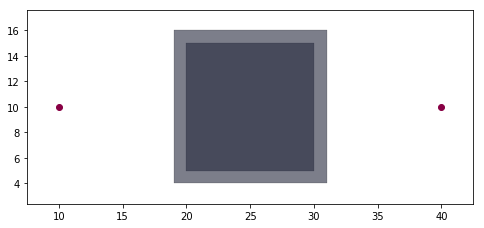

In [211]:
# Visualização desse mapa
vis_mapa(mapa_1)

### Mapa 2

In [12]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (15.0,  8.0), # left, bottom
    (15.0, 20.0), # left, top
    (20.0, 20.0), # right, top
    (20.0,  8.0), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (30.0,  0.0), # left, bottom
    (30.0, 12.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  0.0), # right, bottom
]
verts2.append(verts2[0])
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_2 = Mapa(wp_ori, wp_des, [verts1, verts2], inflation_rate=1)

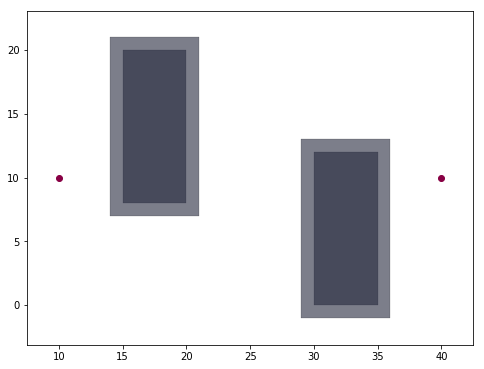

In [13]:
# Visualização desse mapa
vis_mapa(mapa_2)

### Mapa 3

In [14]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (15.0, 11.0), # left, bottom
    (15.0, 25.0), # left, top
    (35.0, 23.0), # right, top
    (35.0, 16.0), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (15.0,  0.0), # left, bottom
    (15.0,  9.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  6.0), # right, bottom
]
verts2.append(verts2[0])
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_3 = Mapa(wp_ori, wp_des, [verts1, verts2], inflation_rate=0.5)

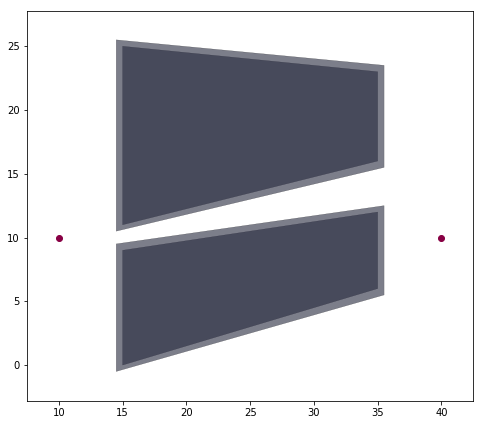

In [15]:
# Visualização desse mapa
vis_mapa(mapa_3)

### Mapa 4

In [16]:
wp_ori = CartesianPoint(40.0, 25.0)
wp_des = CartesianPoint(36.0, -22.0)

verts1 = [
    (19.0,-12.0), # left, bottom
    (15.0,0.0), # left, top
    (87.0,15.0), # right, top
    (90.0,3.0), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

# verts1 = [
#     (38.0,-9.0), # left, bottom
#     (38.0,6.0), # left, top
#     (87.0,15.0), # right, top
#     (90.0,3.0), # right, bottom
# ]
# verts1.append(verts1[0])
# verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (15.0,  0.0), # left, bottom
    (15.0,  9.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  6.0), # right, bottom
]
verts2.append(verts2[0])
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_4 = Mapa(wp_ori, wp_des, [verts1], inflation_rate=0.5)

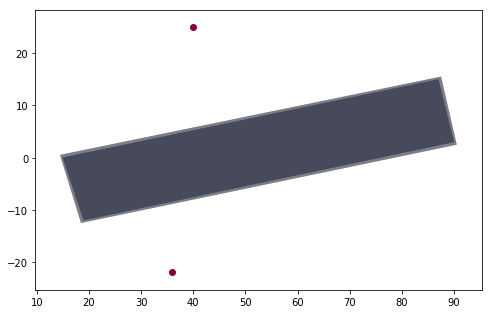

In [17]:
# Visualização desse mapa
vis_mapa(mapa_4)

### Dict

In [18]:
mapas_id = {
    '1': mapa_1,
    '2': mapa_2,
    '3': mapa_3,
    '4': mapa_4
}

## 3.2. Planejamento de Rota

In [17]:
# ===============================================================
# --------------   UTILIZE ESSE ESPAÇO --------------------------

debug = False

# Altere aqui o mapa que deseja utilizar
mapa = mapa_1
#mapa = mapa_2
#mapa = mapa_3
#mapa = mapa_4


# Inicialização do Algoritmo
ag = Genetic(Subject, mapa, 
        version = Version('beta', 'CC'),
        # Parâmetros da classe Genetic:
        taxa_cross=5,       # 5
        population_size=10, # 10
        C_d=10000,           # 1000
        C_obs=10000,        # 10000
        C_con=500,          # 500
        C_cur=100,          # 100
        C_t=100,            # 100
        max_exec_time=1, # segundos
        # Parâmetros da classe Subject:
        px0=mapa.origin.x,
        py0=mapa.origin.y,
        T_min=1,            # 1
        T_max=25,           # 25
        mutation_prob=0.7,  # 0.7
        gps_imprecision=1
)

# ===============================================================

# Execução do AG, retorna o melhor indivíduo
best = ag.run(info=True)

# Print do DNA do melhor
print('-'*30)
for dna in best.dna:
    print(dna)
    
# Print do DNA DECODIFICADO do melhor
print('-'*30)
for dna_decoded in best.dna_decoded:
    print(dna_decoded)
    
best = ag.best

# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)


# Visualização de alguns gráficos de fitness e quantidade de Ts
#plot_stats(ag.trace, normalize=True)
#plot_stats(ag.trace, normalize=False)

Meteoro! Melhor de todos:12370.08713488874 - count:6
Meteoro! Melhor de todos:12370.08713488874 - count:9
Meteoro! Melhor de todos:12360.262272637192 - count:17
Meteoro! Melhor de todos:12360.262272637192 - count:12
Meteoro! Melhor de todos:12360.262272637192 - count:15
Meteoro! Melhor de todos:12336.279379622558 - count:19
Meteoro! Melhor de todos:12336.279379622558 - count:9
Meteoro! Melhor de todos:11545.549770889735 - count:22
Meteoro! Melhor de todos:11545.549770889735 - count:10
Meteoro! Melhor de todos:11545.549770889735 - count:10
Meteoro! Melhor de todos:11545.549770889735 - count:13
Meteoro! Melhor de todos:11545.549770889735 - count:12
Meteoro! Melhor de todos:11368.151218565132 - count:9
Meteoro! Melhor de todos:11368.151218565132 - count:15
Meteoro! Melhor de todos:11368.151218565132 - count:12
Meteoro! Melhor de todos:11368.151218565132 - count:4


KeyboardInterrupt: 

In [ ]:
rota_ruim = best

In [20]:
break

SyntaxError: 'break' outside loop (<ipython-input-20-6aaf1f276005>, line 4)

In [ ]:
best.birth_time

In [20]:
len(ag.ancestry)

191

In [ ]:
A = ag.ancestry[50]
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=A.get_route(), # rota do melhor de todos
)

In [ ]:
debug = True
wp_teste = GeneDecoded(x=19, y=16.5, v=7.8730500357006825, al=0.23615218818588443)

risk_total(wp_teste, mapa.areas_n_inf[0], 5)

In [ ]:
 mapa.areas_n_inf[0]

#### Visualizar Detalhes do fitness

In [ ]:
best.fitness_trace
# Destino Obstáculo Consumo Curva QtdWP

#### Recuperação de Erros
Caso o AG pare no meio da execução, é possível visualizar o melhor de todos gerado até o momento mesmo assim, basta rodar a célula abaixo

In [ ]:
best = ag.best

# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)


# 4. Execução da Implementação em ROS

In [ ]:
mapa_file = [
{
	"id": 0,
	"name": "Mapa C2",
	"geo_home": [-47.932949, -22.002467, 0],
	"areas_bonificadoras":[],
	"areas_penalizadoras":[],
	"areas_nao_navegaveis":[
		{
			"id": "NN1",
			"name": "Campo atras dos containers",
			"geo_points":[
				[-47.932749, -22.002332, 7], 
				[-47.932794, -22.002177, 13], 
				[-47.932664, -22.002147, 13], 
				[-47.932612, -22.002306, 7]
    			]
    		},
		{
			"id": "NN2",
			"name": "Bloco de aula",
			"geo_points":[
				[-47.932099, -22.002278, 20],
				[-47.932063, -22.002396, 20],
				[-47.932772, -22.002582, 20],
				[-47.932811, -22.002465, 20]
			]
		}
    ]
}
]

In [ ]:
mapa_file = [
{
	"id": 0,
	"name": "Mapa C2",
	"geo_home": [-47.932949, -22.002467, 0],
	"areas_bonificadoras":[],
	"areas_penalizadoras":[],
	"areas_nao_navegaveis":[
		{
			"id": "NN1",
			"name": "Bloco de Aula",
			"geo_points":[
				[-47.932754, -22.002590, 7], 
				[-47.932804, -22.002485, 13], 
				[-47.932109, -22.002287, 13], 
				[-47.932072, -22.002401, 7]
    			]
    		},
		{
			"id": "NN2",
			"name": "Containers",
			"geo_points":[
				[-47.933286, -22.002630, 20],
				[-47.933370, -22.002350, 20],
				[-47.933047, -22.002259, 20],
				[-47.932956, -22.002532, 20]
			]
		}
    ]
}
]

In [ ]:
import argparse

#from visualization import plot_map
#from genetic_v2_3 import Subject, Genetic 
#from data_definitions import Mapa, CartesianPoint, Conversor, GeoPoint

#from file_manipulation import read_mapa, write_mavros, upload_mapa

## ENTRADA

# Parâmetros recebidos (arquivo .srv)
origin_lat       = -22.002237
origin_long      = -47.932546
origin_alt       = 13
destination_lat  = -22.002674 
destination_long = -47.932608
destination_alt  = 15

# P0
# destination_lat  = -22.002278 
# destination_long = -47.932099
# destination_alt  = 20

# P1
# destination_lat  = -22.002396 
# destination_long = -47.932063
# destination_alt  = 20


mapa_id          = 0

# Leitura do arquvio em DATA
#PATH = '/home/gustavosouza/Documents/Per/path-planning/data/mapa.json' #Ubuntu
PATH = r'../../data' #Windows
#geo_home, _, _, areas_n = read_mapa(PATH, mapa_id)
geo_home, _, _, areas_n = upload_mapa(mapa_file, mapa_id)

cart_origin      = Conversor.geo_to_cart(GeoPoint(origin_lat, origin_long, origin_alt), geo_home)
cart_destination = Conversor.geo_to_cart(GeoPoint(destination_lat, destination_long, destination_alt), geo_home)


mapa = Mapa(cart_origin, cart_destination, areas_n, inflation_rate=3)



## EXECUÇÃO DO AG
ag_teste = Genetic(Subject, mapa,
        # Genetic
        taxa_cross=0.5,
        population_size=100,
        C_d=1000,
        C_obs=10000,
        C_con=100,
        C_cur=500,
        C_t=100,
        max_exec_time=6000,
        #Subject,
        T_min=10,
        T_max=40,
        mutation_prob=0.7,
        px0=cart_origin.x,
        py0=cart_origin.y
)


best = ag_teste.run(info=True)

# Melhor rota encontrada : WPs em cartesiano
cart_points = best.get_route()

# Melhor rota encontrada : WPs em geográfico
geo_points = [ Conversor.cart_to_geo(CartesianPoint(cart_point[0], cart_point[1]), geo_home) for cart_point in cart_points ]


# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)

## SAÍDA

#output_filename = '/mnt/c/Projetos/path-planning/algorithms/ros_genetic/path_from_ga_output.wp'
#write_mavros(output_filename, geo_points)

In [ ]:
def print_mavros(geo_points): #throws FileNotFoundException
    print('Printing mavros file...\n\n\n')
    count = 1


    current_waypoint = 1

    print('QGC WPL 120\n') # Determines the file version

    i = 0

    for geo_point in geo_points:
        print(
            str(i) + '\t'
            + str(current_waypoint) + '\t' 
            + '3\t16\t3\t0\t0\t0\t'
            + '{:10.8f}'.format(geo_point.longitude) + '\t' 
            + '{:10.8f}'.format(geo_point.latitude) + '\t'
            + '{:10.8f}'.format(geo_point.altitude) + '\t'
            + '1'
            + '\n'
        )

        current_waypoint = 0
        i+=1

    print('\n\n\nOutput print generated.')

In [ ]:
print_mavros(geo_points)

In [ ]:
mapa.areas_n

In [ ]:

areas = [ area for area in itertools.chain(mapa.areas_n) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)


In [ ]:
import argparse

#from visualization import plot_map
#from genetic_v2_3 import Subject, Genetic 
#from data_definitions import Mapa, CartesianPoint, Conversor, GeoPoint

#from file_manipulation import read_mapa, write_mavros, upload_mapa

## ENTRADA

# Parâmetros recebidos (arquivo .srv)
origin_lat       = -22.002237
origin_long      = -47.932546
origin_alt       = 13
destination_lat  = -22.002674 
destination_long = -47.932608
destination_alt  = 15

# P0
# destination_lat  = -22.002278 
# destination_long = -47.932099
# destination_alt  = 20

# P1
# destination_lat  = -22.002396 
# destination_long = -47.932063
# destination_alt  = 20


mapa_id          = 0

# Leitura do arquvio em DATA
#PATH = '/home/gustavosouza/Documents/Per/path-planning/data/mapa.json' #Ubuntu
PATH = r'../../data' #Windows
#geo_home, _, _, areas_n = read_mapa(PATH, mapa_id)
geo_home, _, _, areas_n = upload_mapa(mapa_file, mapa_id)

cart_origin      = Conversor.geo_to_cart(GeoPoint(origin_lat, origin_long, origin_alt), geo_home)
cart_destination = Conversor.geo_to_cart(GeoPoint(destination_lat, destination_long, destination_alt), geo_home)


mapa = Mapa(cart_origin, cart_destination, areas_n, inflation_rate=0.1)



## EXECUÇÃO DO AG
ag_teste = Genetic(Subject, mapa,
        # Genetic
        taxa_cross=0.5,
        population_size=100,
        C_d=1000,
        C_obs=10000,
        C_con=100,
        C_cur=500,
        C_t=1,
        max_exec_time=600,
        #Subject,
        T_min=10,
        T_max=40,
        mutation_prob=0.7,
        px0=cart_origin.x,
        py0=cart_origin.y
)


best = ag_teste.run(info=True)

# Melhor rota encontrada : WPs em cartesiano
cart_points = best.get_route()

# Melhor rota encontrada : WPs em geográfico
geo_points = [ Conversor.cart_to_geo(CartesianPoint(cart_point[0], cart_point[1]), geo_home) for cart_point in cart_points ]


# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)

## SAÍDA

#output_filename = '/mnt/c/Projetos/path-planning/algorithms/ros_genetic/path_from_ga_output.wp'
#write_mavros(output_filename, geo_points)

In [ ]:

best.fitness_trace
# Destino Obstáculo Consumo Curva QtdWP

In [ ]:
best = ag_teste.best

# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)

# 5. Ray Casting Stress Test
Testes de estresse para verificar desempenho do algoritmo Ray Casting

## 5.1. Point in Polygon

In [ ]:
%%time
qty_points = 1


verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
wps = []
for i in range(qty_points):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    
    wp = CartesianPoint(x,y)
    wps.append(wp)
    texts.append(str(point_in_polygon(wp, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    points=wps,
    wp_style='x',
    title='Ray Casting Algorithm - Point in Polygon Stress Test, wp={}'.format(qty_points),
    stress=True
)

In [ ]:
%%time
qty_points = 10


verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
wps = []
for i in range(qty_points):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    
    wp = CartesianPoint(x,y)
    wps.append(wp)
    texts.append(str(point_in_polygon(wp, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    points=wps,
    wp_style='x',
    title='Ray Casting Algorithm - Point in Polygon Stress Test, wp={}'.format(qty_points),
    stress=True
)

In [ ]:
%%time
qty_points = 100


verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
wps = []
for i in range(qty_points):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    
    wp = CartesianPoint(x,y)
    wps.append(wp)
    texts.append(str(point_in_polygon(wp, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    points=wps,
    wp_style='x',
    title='Ray Casting Algorithm - Point in Polygon Stress Test, wp={}'.format(qty_points),
    stress=True
)

In [ ]:
%%time
qty_points = 1000


verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
wps = []
for i in range(qty_points):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    
    wp = CartesianPoint(x,y)
    wps.append(wp)
    texts.append(str(point_in_polygon(wp, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    points=wps,
    wp_style='x',
    title='Ray Casting Algorithm - Point in Polygon Stress Test, wp={}'.format(qty_points),
    stress=True
)

In [ ]:
%%time
qty_points = 10000


verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
wps = []
for i in range(qty_points):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    
    wp = CartesianPoint(x,y)
    wps.append(wp)
    texts.append(str(point_in_polygon(wp, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    points=wps,
    wp_style='x',
    title='Ray Casting Algorithm - Point in Polygon Stress Test, wp={}'.format(qty_points),
    stress=True
)

In [ ]:
%%time
qty_points = 100000


verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
wps = []
for i in range(qty_points):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    
    wp = CartesianPoint(x,y)
    wps.append(wp)
    texts.append(str(point_in_polygon(wp, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    points=wps,
    wp_style='x',
    title='Ray Casting Algorithm - Point in Polygon Stress Test, wp={}'.format(qty_points),
    stress=True
)

## 5.2. Segment intersects polygon

In [ ]:
qty_segments = 15

verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
segments = []
for i in range(qty_segments):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    wp1 = CartesianPoint(x,y)

    x = random.uniform(1,6)
    y = random.uniform(1,6)
    wp2 = CartesianPoint(x,y)

    segment = [wp1, wp2]
    segments.append(segment)
    texts.append(str(segment_in_polygon(wp1, wp2, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    segments=segments,
    wp_style='-x',
    title='RC Algorithm - Segment intersects Segment Stress Test, segments={}'.format(qty_segments),
    stress=True
)

# 6. Automated Experiments

## Def

In [19]:
import pickle

debug = False

def run_ag(mapa, specs):

    ag = Genetic(Subject, mapa, 
        version = Version(specs['version']['major'], specs['version']['minor']),
        # Parâmetros da classe Genetic:
        taxa_cross=specs['taxa_cross'],
        population_size=specs['population_size'],
        C_d=specs['C_d'],
        C_obs=specs['C_obs'],
        C_con=specs['C_con'],
        C_cur=specs['C_cur'],
        C_t=specs['C_t'],
        max_exec_time=specs['max_exec_time'], # segundos
        # Parâmetros da classe Subject:
        px0=specs['px0'],
        py0=specs['py0'],
        T=specs['T'],
        T_min=specs['T_min'],
        T_max=specs['T_max'],
        mutation_prob=specs['mutation_prob']
    )

    
    # Execução do AG, retorna o melhor indivíduo
    best = ag.run(info=True)

    # Print do DNA do melhor
    print('-'*30)
    for dna in best.dna:
        print(dna)
        
    # Print do DNA DECODIFICADO do melhor
    print('-'*30)
    for dna_decoded in best.dna_decoded:
        print(dna_decoded)
        
    best = ag.best

    # Visualização do Mapa usado, com a rota do melhor de todos
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]
    plot_map(
        areas=areas,            # Mapa usado
        labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        origem=mapa.origin,      # waypoint de origem
        destino=mapa.destination, # waypoint de destino
        waypoints=best.get_route(), # rota do melhor de todos
    )


    # Visualização de alguns gráficos de fitness e quantidade de Ts
    #plot_stats(ag.trace, normalize=True)
    #plot_stats(ag.trace, normalize=False)

    return ag

## Run

In [19]:
break

SyntaxError: 'break' outside loop (<ipython-input-19-6aaf1f276005>, line 4)

In [20]:
# mapa_n = '0'
# mapa_n = '1'
# mapa_n = '2'
# mapa_n = '3'
# mapa_n = '4'

major = 'beta'
minor = 'CC'
exec_time = 600 #segundos

PATH = '/home/gustavosouza/Documents/Per/path-planning/parallel/'

EXECUTION_NUMBER = '2'



In [21]:
def define_tests_dict(mapa_n):
    mapa = mapas_id[mapa_n]
    tests = {
        'specs':{
            'mapa': mapa_n,
            'version': {'major': major, 'minor': minor},
            'taxa_cross': 5,
            'population_size': 10,
            'C_d': 100,
            'C_obs': 10000,
            'C_con': 0,
            'C_cur': 0,
            'C_t': 10,
            'max_exec_time': exec_time,
            'px0': mapa.origin.x,
            'py0': mapa.origin.y,
            'T': 10,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7
        },
        'ags': [],
        'res': []
    }
    
    return mapa, tests

In [22]:
def run_test(A):
    mapa_n, i = A
    
    mapa, tests = define_tests_dict(mapa_n)
    
    ag = run_ag(mapa, tests['specs'])
    tests['ags'].append(ag)

    l = [[subject.fitness, subject.birth_time] for subject in ag.ancestry]   
    tests['res'].append(l)
    
    pickle.dump(tests, open(PATH+f"backups/bkp_{EXECUTION_NUMBER}_{major}_{minor}_{int(exec_time/60)}_{mapa_n}_{i}.p", "wb" ))
 

In [23]:
#pickle.dump(tests, open(PATH+f"execution_{EXECUTION_NUMBER}_{major}_{minor}_{int(exec_time/60)}_{mapa_n}.p", "wb" ))

In [24]:
%%time
from multiprocessing import Pool
import numpy as np

p = Pool(40)

Z = [(str(i),j) for i in np.arange(1,5) for j in np.arange(10)]
print(p.map(run_test, Z))

Meteoro! Melhor de todos:2923.8156928334242 - count:7
Meteoro! Melhor de todos:3073.363618147455 - count:5
Meteoro! Melhor de todos:2923.8156928334242 - count:5
Meteoro! Melhor de todos:2485.0686777984843 - count:6
Meteoro! Melhor de todos:2267.6083019299076 - count:4
Meteoro! Melhor de todos:3035.284632663805 - count:8
Meteoro! Melhor de todos:2925.1244611745124 - count:12
Meteoro! Melhor de todos:2892.4537657851106 - count:11
Meteoro! Melhor de todos:2923.8156928334242 - count:7
Meteoro! Melhor de todos:2897.585520438259 - count:14
Meteoro! Melhor de todos:2923.8156928334242 - count:14
Meteoro! Melhor de todos:2896.99195120649 - count:16
Meteoro! Melhor de todos:2897.0238427599293 - count:17
Meteoro! Melhor de todos:3133.917060961682 - count:7
Meteoro! Melhor de todos:1542.1014120764605 - count:9
Meteoro! Melhor de todos:3168.9627373643384 - count:10
Meteoro! Melhor de todos:2925.1279106436245 - count:17
Meteoro! Melhor de todos:2923.8156928334242 - count:7
Meteoro! Melhor de todos:3

Process ForkPoolWorker-2:
Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-33:
Process ForkPoolWorker-39:
Process ForkPoolWorker-35:
Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-9:
Process ForkPoolWorker-28:
Process ForkPoolWorker-37:
Process ForkPoolWorker-23:
Process ForkPoolWorker-15:
Process ForkPoolWorker-5:
Process ForkPoolWorker-25:
Process ForkPoolWorker-34:
Process ForkPoolWorker-40:
Process ForkPoolWorker-31:
Process ForkPoolWorker-30:
Process ForkPoolWorker-32:
Process ForkPoolWorker-24:
Process ForkPoolWorker-11:
Process ForkPoolWorker-38:
Process ForkPoolWorker-18:
Process ForkPoolWorker-13:
Process ForkPoolWorker-16:
Process ForkPoolWorker-12:
Process ForkPoolWorker-14:
Process ForkPoolWorker-36:
Process ForkPoolWorker-27:
Process ForkPoolWorker-26:
Process ForkPoolWorker-22:
Process ForkPoolWorker-3:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Process ForkPoolWorker-29:
Process F

  File "<ipython-input-8-79a9a1dd1185>", line 96, in run
    self._fitness(child, self.mapa)
  File "<ipython-input-8-79a9a1dd1185>", line 96, in run
    self._fitness(child, self.mapa)
  File "<ipython-input-22-fa139df7d7e0>", line 6, in run_test
    ag = run_ag(mapa, tests['specs'])
  File "<ipython-input-7-1acf4adfb448>", line 226, in __BLX_ALpha_select_gene
    u = random.uniform(min(x,y)-alpha*d, max(x,y)+alpha*d)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-7-1acf4adfb448>", line 172, in crossover
    child = self.generate(dna)
  File "<ipython-input-8-79a9a1dd1185>", line 212, in _fitness
    fit_obs = self.__fitness_obstacles(subject, mapa)
  File "<ipython-input-8-79a9a1dd1185>", line 212, in _fitness
    fit_obs = self.__fitness_obstacles(subject, mapa)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-8-79a9a1dd

KeyboardInterrupt
  File "<string>", line 14, in __new__
KeyboardInterrupt
  File "<ipython-input-8-79a9a1dd1185>", line 96, in run
    self._fitness(child, self.mapa)
  File "/usr/lib/python3.6/random.py", line 258, in choice
    i = self._randbelow(len(seq))
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-8-79a9a1dd1185>", line 212, in _fitness
    fit_obs = self.__fitness_obstacles(subject, mapa)
  File "<ipython-input-1-90a79401924d>", line 217, in _distance_wp_area
    for A, B in pairwise_circle(area):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-79a9a1dd1185>", line 291, in __fitness_obstacles_CC
    risk = _prob_collision(distance, uncertainty)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-1-90a79401924d>", line 275, in _prob_collision
    return norm.sf(distance, loc=0, scale=uncertainty)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-19-5d97e0ee97fc>", line 29, in run_ag
    best = ag.run(info=True)
  File "<ipython-input-8-79a9a1dd1185>", line 96, in run
    self._fitness(child, self.mapa)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.6/multiproces

  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-8-79a9a1dd1185>", line 212, in _fitness
    fit_obs = self.__fitness_obstacles(subject, mapa)
  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py", line 1899, in sf
    place(output, cond, self._sf(*goodargs))
  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py", line 1898, in sf
    goodargs = argsreduce(cond, *((x,)+args))
  File "<ipython-input-22-fa139df7d7e0>", line 6, in run_test
    ag = run_ag(mapa, tests['specs'])
  File "<ipython-input-1-90a79401924d>", line 275, in _prob_collision
    return norm.sf(distance, loc=0, scale=uncertainty)
  File "<ipython-input-1-90a79401924d>", line 275, in _prob_collision
    return norm.sf(distance, loc=0, scale=uncertainty)
KeyboardInterrupt
  File "<ipython-input-8-79a9a1dd1185>", line 254, in __fitness_obstacles
    return self.__fitness_obstacles_CC(subj

  File "<ipython-input-8-79a9a1dd1185>", line 139, in run
    self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-1-90a79401924d>", line 275, in _prob_collision
    return norm.sf(distance, loc=0, scale=uncertainty)
KeyboardInterrupt
  File "<ipython-input-1-90a79401924d>", line 275, in _prob_collision
    return norm.sf(distance, loc=0, scale=uncertainty)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python

  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py", line 1898, in sf
    goodargs = argsreduce(cond, *((x,)+args))
  File "<ipython-input-8-79a9a1dd1185>", line 96, in run
    self._fitness(child, self.mapa)
  File "<ipython-input-22-fa139df7d7e0>", line 6, in run_test
    ag = run_ag(mapa, tests['specs'])
  File "<ipython-input-19-5d97e0ee97fc>", line 29, in run_ag
    best = ag.run(info=True)
  File "<ipython-input-22-fa139df7d7e0>", line 6, in run_test
    ag = run_ag(mapa, tests['specs'])
  File "/usr/lib/python3.6/copy.py", line 180, in deepcopy
    y = _reconstruct(x, memo, *rv)
  File "<ipython-input-22-fa139df7d7e0>", line 6, in run_test
    ag = run_ag(mapa, tests['specs'])
  File "<ipython-input-8-79a9a1dd1185>", line 96, in run
    self._fitness(child, self.mapa)
KeyboardInterrupt
  File "<ipython-input-22-fa139df7d7e0>", line 6, in run_test
    ag = run_ag(mapa, tests['specs'])
  File "<ipython-input-8-79a9a1dd1185>", line 96, in run
    se

  File "<ipython-input-8-79a9a1dd1185>", line 291, in __fitness_obstacles_CC
    risk = _prob_collision(distance, uncertainty)
  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py", line 1898, in sf
    goodargs = argsreduce(cond, *((x,)+args))
  File "<ipython-input-8-79a9a1dd1185>", line 212, in _fitness
    fit_obs = self.__fitness_obstacles(subject, mapa)
  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py", line 1895, in sf
    place(output, (1-cond0)+np.isnan(x), self.badvalue)
  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py", line 1886, in sf
    x, loc, scale = map(asarray, (x, loc, scale))
  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py", line 1898, in sf
    goodargs = argsreduce(cond, *((x,)+args))
  File "/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
  

KeyboardInterrupt: 

Process ForkPoolWorker-69:
Process ForkPoolWorker-75:
Process ForkPoolWorker-71:
Process ForkPoolWorker-79:
Process ForkPoolWorker-62:
Process ForkPoolWorker-66:
Process ForkPoolWorker-45:
Process ForkPoolWorker-57:
Process ForkPoolWorker-55:
Process ForkPoolWorker-65:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-46:
Process ForkPoolWorker-78:
Process ForkPoolWorker-77:
Process ForkPoolWorker-63:
Process ForkPoolWorker-61:
Process ForkPoolWorker-56:
Process ForkPoolWorker-47:
Process ForkPoolWorker-70:
Process ForkPoolWorker-54:
Process ForkPoolWorker-60:
Process ForkPoolWorker-68:
Process ForkPoolWorker-53:
Process ForkPoolWorker-43:
Process ForkPoolWorker-80:
Process ForkPoolWorker-58:
Process ForkPoolWorker-51:
Process ForkPoolWorker-52:
Process ForkPoolWorker-49:
Process ForkPoolWorker-44:
Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/pytho

  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/sy

In [25]:
Z = [(str(i),j) for i in np.arange(1,5) for j in np.arange(10)]

## Visualization

In [26]:
import matplotlib.pylab as pl

In [27]:
def read_saves():
    saves = []
    
    for mapa_n in np.arange(1,5):
        save = {
            'mapa_n': str(mapa_n),
            'ags': [],
            'res': []
        }
        
        for i in np.arange(10):
            with open(PATH+f"backups/bkp_{EXECUTION_NUMBER}_{major}_{minor}_{int(exec_time/60)}_{mapa_n}_{i}.p", "rb" ) as f:
                save_tests = pickle.load(f)
                save['ags'].extend(save_tests['ags'])
                save['res'].extend(save_tests['res'])
                
        saves.append(save)
                
    return saves

In [28]:
saves = read_saves()
saves

[{'mapa_n': '1',
  'ags': [<__main__.Genetic at 0x7fb3e930f080>,
  'res': [[[3169.559907295417, 0.08353567123413086],
    [2809.3695585086166, 0.141798734664917],
    [2623.366196677244, 0.28482937812805176],
    [2501.8441170787464, 0.5627334117889404],
    [2452.3109179229673, 8.271553039550781],
    [2387.3721696689468, 15.380680322647095],
    [2352.1467662565624, 15.480966091156006],
    [1838.3194791082592, 16.379390716552734],
    [1756.9402752760298, 21.59211802482605],
    [1686.3290794845898, 22.36600661277771],
    [794.795897534283, 43.520543813705444],
    [751.1197405570741, 44.25167989730835],
    [671.3859750709325, 47.059749126434326],
    [590.4797271269338, 55.958704710006714],
    [470.9976833917957, 66.35204076766968],
    [450.4519342895964, 68.90523529052734],
    [403.57687815092305, 98.12100577354431],
    [329.02846862737, 165.16056537628174],
    [313.2615425428724, 167.68606209754944],
    [312.93130915131553, 169.8163502216339],
    [312.6283759478633, 170.

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Resultados da Alocação de Risco

 eixo x: tempo em que foi encontrada a melhor solução (em segundos)
 eixo y: fitness do melhor de todos
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


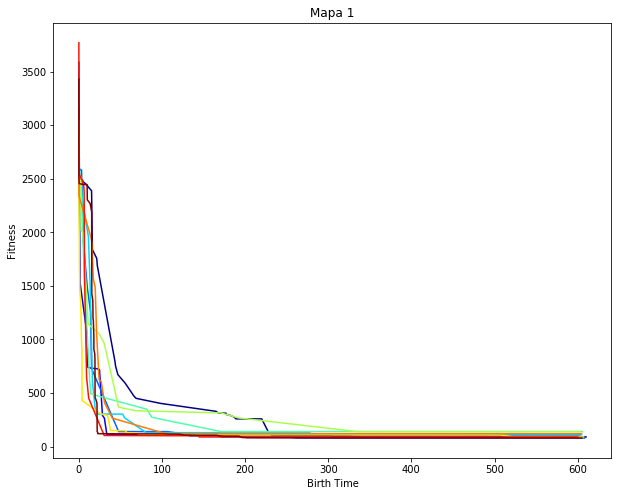

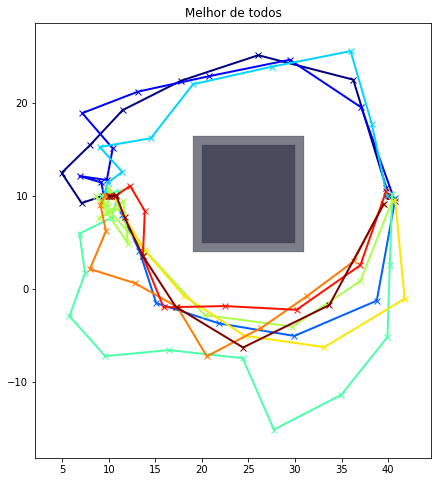

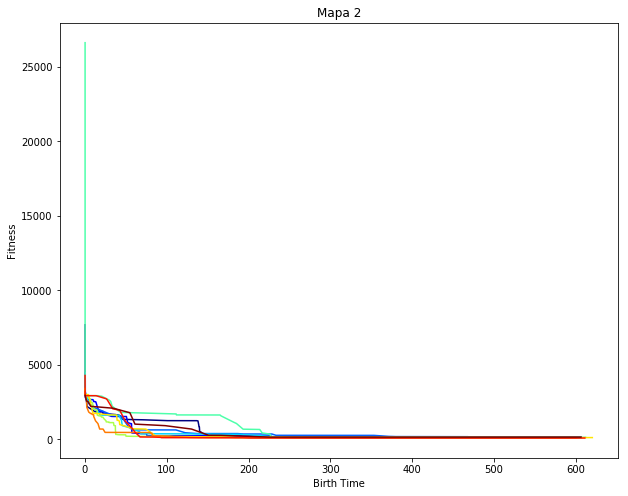

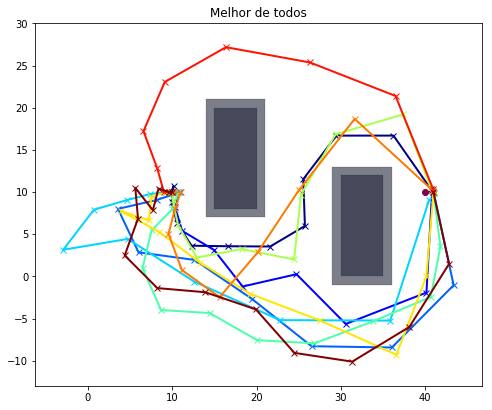

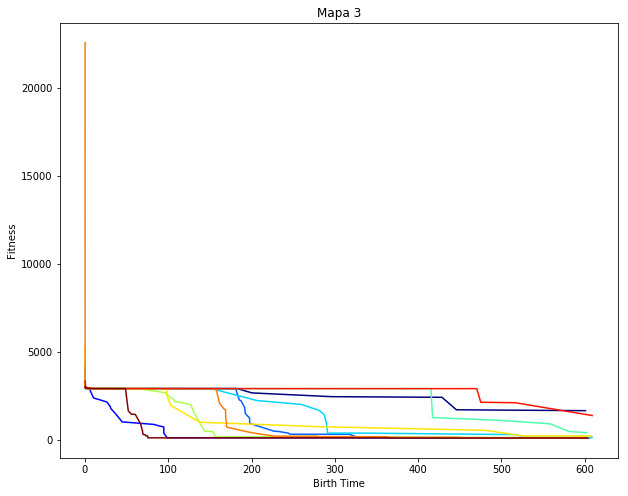

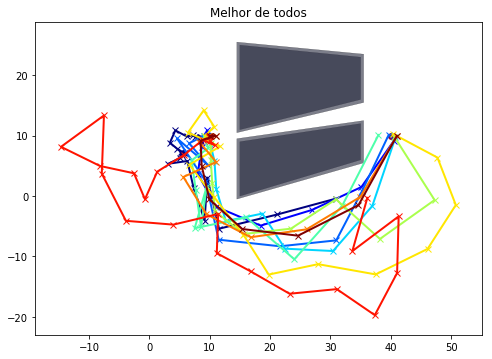

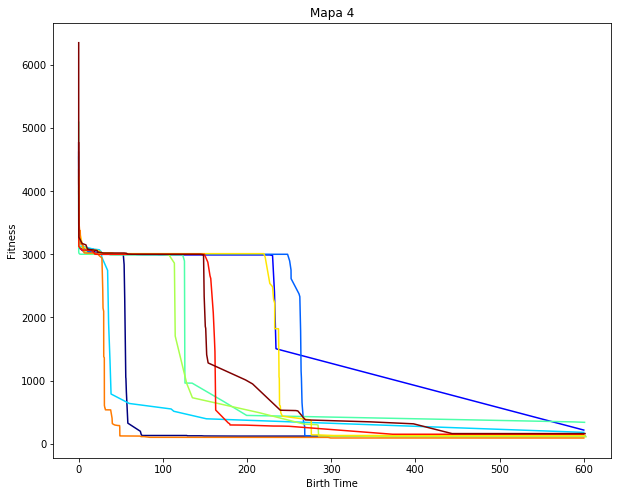

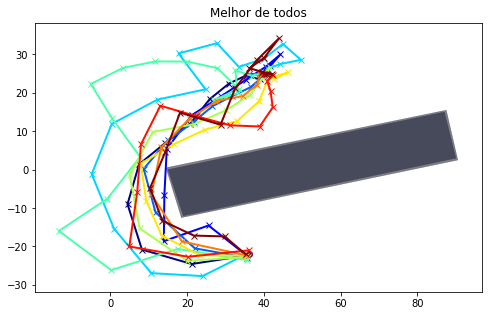

In [29]:
print('X'*80)
print('Resultados da Alocação de Risco\n\n eixo x: tempo em que foi encontrada a melhor solução (em segundos)\n eixo y: fitness do melhor de todos')


for save in saves: 

    print('-'*80)
    mapa_n = save['mapa_n']
    
    mapa = mapas_id[mapa_n]

    n = len(save['res'])

    colors = pl.cm.jet(np.linspace(0,1,n))

    plt.figure(figsize=(10,8))
    plt.title(f'Mapa {mapa_n}')
    plt.xlabel('Birth Time')
    plt.ylabel('Fitness')
    for i in range(n):
        np_ar = np.array(save['res'][i])
        plt.plot(np_ar[:,1], np_ar[:,0], color=colors[i])


    routes = []
    names = []
    for i in range(n):
        routes.append(save['ags'][i].best.get_route())
        names.append('execução '+str(i))

    # Visualização do Mapa usado, com a rota do melhor de todos
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]
    plot_map(
        areas=areas,            # Mapa usado
        labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        origem=mapa.origin,      # waypoint de origem
        destino=mapa.destination, # waypoint de destino
        multi_waypoints=routes, # rotas do melhores de todos
        colors=colors,
        title='Melhor de todos',
        names=names
    )

print('X'*80)

#### Post-processing

In [30]:
buffer = []
import markdown
with open(PATH+'export/Calculo_Alocação_de_Risco_Gustavo.md', 'r') as f:
    flag = -1
    htmlmarkdown = markdown.markdown( f.read() )
    print(htmlmarkdown)
    
#     for line in htmlmarkdown:
#         print(line)
#         if line == 'X'*80:
#             flag *= -1
#             continue
            
#         if flag == 1:
#             buffer.append(line)
            
    
# with open(PATH+'export/Calculo_Alocação_de_Risco_Gustavo_edited.md', 'w') as f:
#     for line in buffer:
#         f.writeline(line)
            

KeyboardInterrupt: 

#### Original

In [ ]:
print('Resultados do Ray Casting\n\n eixo x: tempo em que foi encontrada a melhor solução (em segundos)\n eixo y: fitness do melhor de todos')

# EXECUTION_NUMBER=1
# major
# minor
# exec_time



for mapa_n in ['1', '2', '3', '4']: 
    with open(PATH+f"execution_{EXECUTION_NUMBER}_{major}_{minor}_{int(exec_time/60)}_{mapa_n}.p", 'rb') as f:
        vis_tests = pickle.load(f)
        print('-'*80)
        
        mapa = mapas_id[mapa_n]
                
        n = len(vis_tests['res'])
        
        colors = pl.cm.jet(np.linspace(0,1,n))
        
        plt.figure(figsize=(10,8))
        plt.title(f'Mapa {mapa_n}')
        plt.xlabel('Birth Time')
        plt.ylabel('Fitness')
        for i in range(n):
            np_ar = np.array(vis_tests['res'][i])
            plt.plot(np_ar[:,1], np_ar[:,0], color=colors[i])
        
            
        routes = []
        names = []
        for i in range(n):
            routes.append(vis_tests['ags'][i].best.get_route())
            names.append('execução '+str(i))
            
        # Visualização do Mapa usado, com a rota do melhor de todos
        areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
        tipos = [ 'n' for _ in range(len(areas))]
        plot_map(
            areas=areas,            # Mapa usado
            labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
            origem=mapa.origin,      # waypoint de origem
            destino=mapa.destination, # waypoint de destino
            multi_waypoints=routes, # rotas do melhores de todos
            colors=colors,
            title='Melhor de todos',
            names=names
        )




# 7. Alocação de Risco

In [ ]:
def print_rota_risks(rota):
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]
    plot_map(
        areas=areas,            # Mapa usado
        labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        origem=mapa.origin,      # waypoint de origem
        destino=mapa.destination, # waypoint de destino
        waypoints=rota.get_route(), # rota do melhor de todos
        texts=__fitness_obstacles_CC(rota,mapa)
    )
    for i, dna_decoded in enumerate(rota.dna_decoded):
        print(i, dna_decoded)


### 7.1. Testes

#### 7.1.1. Função de Probabilidade ( 1 - CDF )

In [ ]:
x = np.arange(-20.0,20.0,0.2)
y1=_prob_collision(x, 1)
y2=_prob_collision(x, 5)
y3=_prob_collision(x, 10)
y4=_prob_collision(x, 100)
# plt.plot(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines',
                    name='Uncert. = 1'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines',
                    name='Uncert. = 5'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines',
                    name='Uncert. = 10'))
fig.add_trace(go.Scatter(x=x, y=y4,
                    mode='lines',
                    name='Uncert. = 100'))
fig.show()

#### 7.1.2. Função de Distância: Ponto - Linha

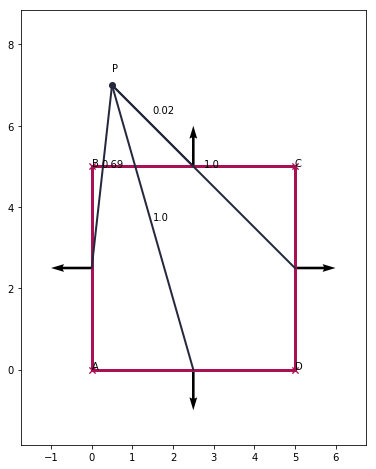

In [157]:
A = CartesianPoint(0,0)
B = CartesianPoint(0,5)
C = CartesianPoint(5,5)
D = CartesianPoint(5,0)

segments = [[A,B], [B,C], [C,D], [D,A]]
segment_texts = [['A','B'],['',''],['C','D'],['','']]


points = [
    CartesianPoint(0.5,7)
]
point_texts = [
    'P'
]

distances = []
normals = []

for P in points:
    for (A, B) in segments:
        dist, normal = d_distance_wp_line(P, A, B)
        distances.append(dist)
        normals.append(normal)
    

plot_map(
    margin=1.5,
    stress=True,
    chance=True,
    segments=segments,
    segment_texts=segment_texts,
    normals=normals,
    pointes=points,
    point_texts=point_texts,
    #distances=distances
    distances=np.around(_prob_collision(distances, 1),2)
)

In [158]:
normals

[Vector(x=-0.9999999980000001, y=0.0),
 Vector(x=0.0, y=0.9999999980000001),
 Vector(x=0.9999999980000001, y=0.0),
 Vector(x=0.0, y=-0.9999999980000001)]

In [ ]:
distances

#### 7.1.3. Fitness Obstáculos Rota

In [ ]:
debug = True


# print('Alocação de Risco: ', test__fitness_obstacles_CC(rota_boa, mapa))
# print_rota_risks(rota_boa)
# print('\n\n'+'='*120+'\n\n')

print_rota_risks(rota_ruim)

In [ ]:
rota_ruim.dna_decoded

# 8. More maps

In [44]:
def read_sgl(path, **kwargs):
    with open(path, 'r') as f:
        lines = f.readlines()  
        map = Mapa(wp_ori, wp_des, sgl_read_areas(lines), **kwargs) #inflation_rate=1, mode='scalar'
    return map



In [31]:
def sgl_read_areas(lines):
    """From the map file definition reads each area"""
    
    lines = iter(lines)
    next(lines)  # <number of polygons>
    next(lines)  # 20

    areas = []
    
    for line in lines:
        Xs = [float(n) for n in re.sub(r'\n', '', next(lines)).split(',')]
        Ys = [float(n) for n in re.sub(r'\n', '', next(lines)).split(',')]

        areas.append([CartesianPoint(x, y) for x, y in zip(Xs, Ys)])

        
    return areas

In [214]:
def run_ags_over_path(path):
    path = str(path)
    number = re.sub(r'[A-Za-z/\-_\.]','',path)
    print(f'1. Processing file: {number}')
    map = read_sgl(path)

    print('1.1. Read')

    ag = Genetic(Subject, map, 
        version = Version('beta', 'CC'),
        # Parâmetros da classe Genetic:
        taxa_cross=5,
        population_size=10,
        max_exec_time=60,
        # Parâmetros da classe Subject:
        px0=map.origin.x,
        py0=map.origin.y,
        T_min=1,
        T_max=25,
        mutation_prob=0.7,
        gps_imprecision=1,
        **par_RC
    )

    best = ag.run(info=False)
    print(f'2. AG generated: {number}')

    name = re.sub(r'(\.sgl)', SUFIX+r'.png', path)
    vis_mapa(map, best.get_route(), save=name)


    name = re.sub(r'(\.sgl)', SUFIX+r'_ag.p', path)

    with open(name, "wb" ) as ag_file:
        pickle.dump(ag, ag_file)

    print(f'2. Saved: {number}')



In [33]:
from pathlib import Path as PPath
import re
from multiprocessing import Pool
import pickle

In [34]:
PATH = "/home/gustavosouza/Documents/Per/path-planning/"
MAPS_PATH = PATH + "maps/NonRegular/"

In [ ]:
# Run all maps and paralellize the execution

pathlist = PPath(MAPS_PATH).glob('**/*.sgl')

par_RC = {
    'C_d': 10000,
    'C_obs': 10000,
    'C_con': 500,
    'C_cur': 100,
    'C_t': 100,
} # used on ray_casting 


SUFIX = '__rc___'


wp_ori = CartesianPoint(0,0)
wp_des = CartesianPoint(0,-10)

# Iterate over different maps
p = Pool(processes=50)
p.map(run_ags_over_path, pathlist)

In [ ]:
# Run one map only

par_RC = {
    "C_d": 10000,
    "C_obs": 10000,
    "C_con": 500,
    "C_cur": 100,
    "C_t": 100,
    "min_precision": 0.5,
}

wp_ori = CartesianPoint(0, 0)
wp_des = CartesianPoint(0, -10)
run_ags_over_path_E(MAPS_PATH + "XXXmap_W20_023.sgl")

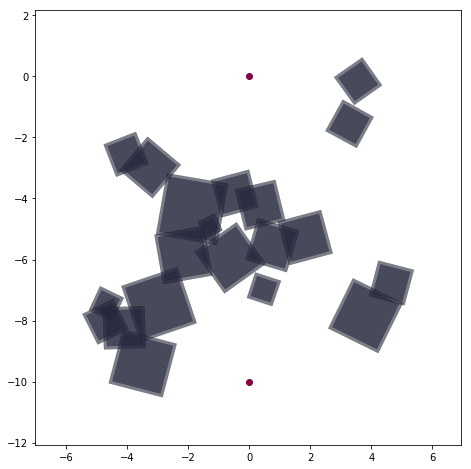

In [213]:
wp_ori = CartesianPoint(0, 0)
wp_des = CartesianPoint(0, -10)
mapa_teste = read_sgl(MAPS_PATH + "map_W20_023.sgl", inflation_rate=0.1, mode='vector')
vis_mapa (mapa_teste)

### Visualization

In [ ]:
def read_saves_sgl():
    saves = []
    
    pathlist = PPath(PATH+"maps/Ags/").glob('**/10m_2_*.p')

    
    for path in pathlist:
        path = str(path)
        with open(path, 'rb') as f:
            ag = pickle.load(f)
    
            save = {
                'mapa_n': re.sub(r'(\/?[\w-]*\/)|(_ag\.p)', '', path),
                'ags': [],
                'res': []
            }
            
    
            l = [[subject.fitness, subject.birth_time] for subject in ag.ancestry]   
            save['res'].append(l)
            save['ags'].append(ag)
                
        saves.append(save)
                
    return saves

In [ ]:
saves_sgl = read_saves_sgl()

In [ ]:
print('X'*80)
print('Resultados da Alocação de Risco\n\n eixo x: tempo em que foi encontrada a melhor solução (em segundos)\n eixo y: fitness do melhor de todos')

wp_ori = CartesianPoint(0,0)
wp_des = CartesianPoint(0,-10)

for save in saves_sgl: 

    #print('-'*80)
    
    mapa_n = re.sub(r'(10m_2_)','',save['mapa_n'])
    with open(f'{PATH}maps/NonRegular/{mapa_n}.sgl', 'r') as f:
        lines = f.readlines()  
        mapa = Mapa(wp_ori, wp_des, sgl_read_areas(lines), inflation_rate=0)
                    
    n = len(save['res'])

    colors = pl.cm.jet(np.linspace(0,1,n))

    plt.figure(figsize=(10,8))
    plt.title(f'Mapa {mapa_n}')
    plt.xlabel('Birth Time')
    plt.ylabel('Fitness')
    for i in range(n):
        ag = save['ags'][i]
        np_ar = np.array(save['res'][i])
        plt.plot(np_ar[:,1], np_ar[:,0], color=colors[i])

        sub_colors = pl.cm.jet(np.linspace(0,1,7))

        sub_routes = []
        sub_names = []
        table = []
        for a, j in enumerate([5, 10, 20, 30, 40, 50, 60]):
            index = get_specific(np_ar, j)
            point = np_ar[index]
            plt.vlines(point[1], 0, point[0], color=sub_colors[a], linestyle="dashed", linewidth=1, alpha=0.8, label=str(j))
            plt.hlines(point[0], 0, point[1], color=sub_colors[a], linestyle="dashed", linewidth=1, alpha=0.8)
            table.append(np.append(index,np.append(point, j)))
            #plt.legend(['Fitness',5,10,20,30,40,50,60])
            plt.legend()
            sub_routes.append(ag.ancestry[index].get_route())
            sub_names.append(str(j))

        table = pd.DataFrame(table)
        table.columns = ['Individual #','Fitness','Real Birth Time','Margin Birth Time']
        print(table.iloc[:, ::-1].round(2))

        # Visualização do Mapa usado, com a rota do melhor de todos
        areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
        tipos = [ 'n' for _ in range(len(areas))]
        plot_map(
            areas=areas,            # Mapa usado
            labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
            origem=mapa.origin,      # waypoint de origem
            destino=mapa.destination, # waypoint de destino
            multi_waypoints=sub_routes, # rotas do melhores de todos
            colors=sub_colors,
            title='Melhor de todos',
            names=sub_names
        )
        


    routes = []
    names = []
    for i in range(n):
        routes.append(save['ags'][i].best.get_route())
        names.append('execução '+str(i))

    # Visualização do Mapa usado, com a rota do melhor de todos
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]
    plot_map(
        areas=areas,            # Mapa usado
        labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        origem=mapa.origin,      # waypoint de origem
        destino=mapa.destination, # waypoint de destino
        multi_waypoints=routes, # rotas do melhores de todos
        colors=colors,
        title='Melhor de todos',
        names=names
    )

print('X'*80)

In [ ]:
np2 = np_ar.copy()

In [ ]:
np.where(np.isclose(np2, 8.894960403442383))[0][0]

In [ ]:
np2[:,1].flat[np.abs(np2[:,1] - 10).argmin()]

In [ ]:
def get_specific(array, birth_time_target):
    # returns index of element with closest birth time as the one provided in an array
    birth_time_specific = np2[:,1].flat[np.abs(np2[:,1] - birth_time_target).argmin()]
    return np.where(np.isclose(np2, birth_time_specific))[0][0]

In [ ]:
get_specific(np2, 500)

In [ ]:
plt.figure(figsize=(10,8))
plt.title(f'Mapa {mapa_n}')
plt.xlabel('Birth Time')
plt.ylabel('Fitness')
for i in range(n):
    ag = save['ags'][i]
    np_ar = np.array(save['res'][i])
    plt.plot(np_ar[:,1], np_ar[:,0], color=colors[i])
    
    sub_colors = pl.cm.jet(np.linspace(0,1,7))
    
    sub_routes = []
    sub_names = []
    table = []
    for a, j in enumerate([5, 10, 20, 30, 40, 50, 60]):
        index = get_specific(np_ar, j)
        point = np_ar[index]
        plt.vlines(point[1], 0, point[0], color=sub_colors[a], linestyle="dashed", linewidth=1, alpha=0.8, label=str(j))
        plt.hlines(point[0], 0, point[1], color=sub_colors[a], linestyle="dashed", linewidth=1, alpha=0.8)
        table.append(np.append(index,np.append(point, j)))
        #plt.legend(['Fitness',5,10,20,30,40,50,60])
        plt.legend()
        sub_routes.append(ag.ancestry[index].get_route())
        sub_names.append(str(j))
        
    table = pd.DataFrame(table)
    table.columns = ['Individual #','Fitness','Real Birth Time','Margin Birth Time']
    print(table.iloc[:, ::-1].round(2))
    
    # Visualização do Mapa usado, com a rota do melhor de todos
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]
    plot_map(
        areas=areas,            # Mapa usado
        labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        origem=mapa.origin,      # waypoint de origem
        destino=mapa.destination, # waypoint de destino
        multi_waypoints=sub_routes, # rotas do melhores de todos
        colors=sub_colors,
        title='Melhor de todos',
        names=sub_names
    )

In [ ]:
get_specific(np_ar, 50)

In [ ]:
np_ar